# Implementación de la simulación

In [1]:
import heapq
import random
import numpy as np

def simulate(s, lambda1, lambda2, t1, t2, tk, sim_time):
    # Convertir tiempos medios de servicio (minutos) a tasas por hora
    mu1 = 60 / t1
    mu2 = 60 / t2

    # Inicialización de variables básicas de la simulación
    time = 0.0
    events = []

    # Configuración inicial según la estrategia
    if s == 'specialized':
        # Sistema con dos colas independientes y servidores especializados
        queues = [[], []]          # Colas separadas para pagos (0) y cobros (1)
        servers = [False, False]   # Estado de los servidores (ocupado/libre)
        clients_in_system = [0, 0] # Clientes en cada subsistema

        # Programar las primeras llegadas para cada tipo
        heapq.heappush(events, (random.expovariate(lambda1), 'arrival', 0))
        heapq.heappush(events, (random.expovariate(lambda2), 'arrival', 1))
    else:
        # Sistema con cola única y servidores generalistas
        queue = []                 # Cola única compartida
        servers = [False, False]   # Estado de los servidores
        clients_in_system = 0      # Clientes totales en el sistema

        # Programar primera llegada combinada
        heapq.heappush(events, (random.expovariate(lambda1 + lambda2), 'arrival'))

    # Variables para recolección de estadísticas
    area_clients = 0.0      # Integral de clientes en el sistema
    prev_time = 0.0         # Tiempo anterior para cálculo de áreas
    waiting_times = []      # Lista de tiempos de espera registrados
    server_busy = [0.0, 0.0] # Tiempo acumulado de ocupación por servidor

    def update_stats(current_time):
        # Actualiza estadísticas acumulativas hasta el tiempo actual
        nonlocal prev_time, area_clients
        delta = current_time - prev_time

        if s == 'specialized':
            # Cálculo para sistema especializado
            total_clients = clients_in_system[0] + clients_in_system[1]
            area_clients += total_clients * delta
            # Actualiza tiempo ocupado de cada servidor
            for i in range(2):
                if servers[i]:
                    server_busy[i] += delta
        else:
            # Cálculo para sistema generalista
            area_clients += clients_in_system * delta
            # Actualiza tiempo ocupado de los servidores
            for i in range(2):
                if servers[i]:
                    server_busy[i] += delta
        prev_time = current_time

    # Procesamiento principal de eventos
    while time < sim_time:
        event = heapq.heappop(events)
        event_time, event_type, *args = event

        # Finalizar simulación si se excede el tiempo
        if event_time > sim_time:
            break

        # Actualizar estadísticas hasta el momento del evento
        update_stats(event_time)
        time = event_time

        if event_type == 'arrival':
            # Manejo de llegadas de clientes
            if s == 'specialized':
                queue_idx = args[0]
                arrival_time = time
                queues[queue_idx].append(arrival_time)
                clients_in_system[queue_idx] += 1

                # Atender cliente si el servidor correspondiente está libre
                if not servers[queue_idx]:
                    servers[queue_idx] = True
                    queues[queue_idx].pop(0)
                    service_time = random.expovariate(mu1 if queue_idx == 0 else mu2)
                    heapq.heappush(events, (time + service_time, 'departure', queue_idx))
                    waiting_times.append(0.0)  # Sin tiempo de espera

                # Programar próxima llegada para esta cola
                next_arrival = time + random.expovariate(lambda1 if queue_idx == 0 else lambda2)
                heapq.heappush(events, (next_arrival, 'arrival', queue_idx))
            else:
                arrival_time = time
                queue.append(arrival_time)
                clients_in_system += 1

                # Asignar cliente a servidor disponible
                for i in range(2):
                    if not servers[i]:
                        servers[i] = True
                        service_time = random.expovariate(mu1)
                        heapq.heappush(events, (time + service_time, 'departure', i))
                        queue.pop(0)
                        waiting_times.append(0.0)  # Sin tiempo de espera
                        break

                # Programar próxima llegada combinada
                next_arrival = time + random.expovariate(lambda1 + lambda2)
                heapq.heappush(events, (next_arrival, 'arrival'))

        elif event_type == 'departure':
            # Manejo de salidas de clientes
            server_idx = args[0]

            if s == 'specialized':
                clients_in_system[server_idx] -= 1

                # Atender siguiente cliente en la cola si existe
                if queues[server_idx]:
                    arrival_time = queues[server_idx].pop(0)
                    waiting_times.append(time - arrival_time)
                    service_time = random.expovariate(mu1 if server_idx == 0 else mu2)
                    heapq.heappush(events, (time + service_time, 'departure', server_idx))
                else:
                    servers[server_idx] = False
            else:
                clients_in_system -= 1

                # Atender siguiente cliente de la cola compartida
                if queue:
                    arrival_time = queue.pop(0)
                    waiting_times.append(time - arrival_time)
                    service_time = random.expovariate(mu1)
                    heapq.heappush(events, (time + service_time, 'departure', server_idx))
                else:
                    servers[server_idx] = False

    # Actualizar estadísticas finales
    update_stats(sim_time)

    # Cálculo de métricas finales
    L = area_clients / sim_time  # Clientes promedio en el sistema
    Wq = np.mean(waiting_times) * 60 if waiting_times else 0.0  # Tiempo de espera en minutos
    P_Wq_over_tk = np.mean(np.array(waiting_times) > tk/60) if waiting_times else 0.0  # P(Wq > tk)
    t_free = 1 - sum(server_busy)/(2 * sim_time)  # Tiempo promedio inactivo por servidor

    return {
        'L': L,
        'Wq': Wq,
        'P_Wq_over_tk': P_Wq_over_tk,
        't_free': t_free
    }

# Comparación Servidores Especializados vs Generalistas

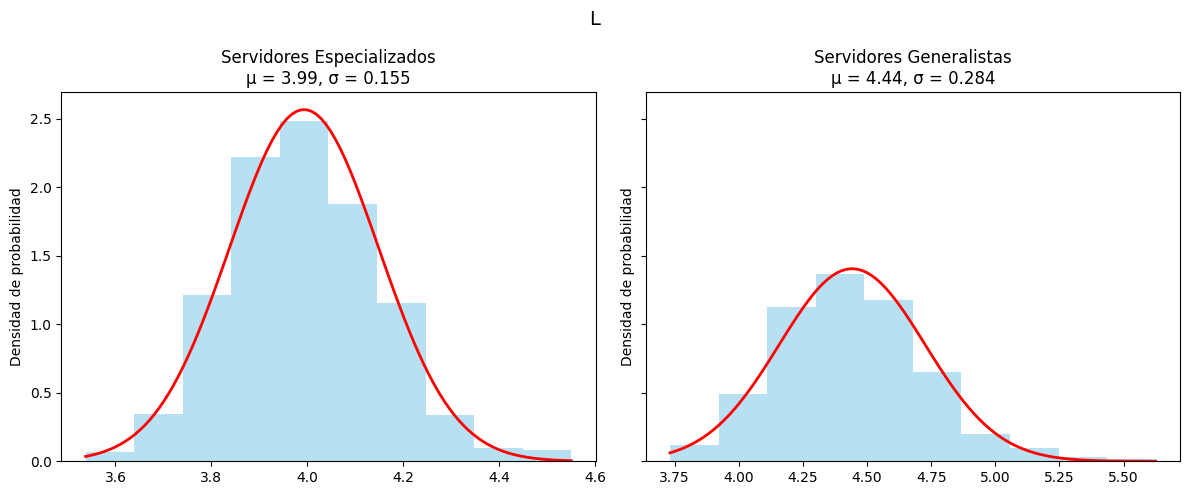

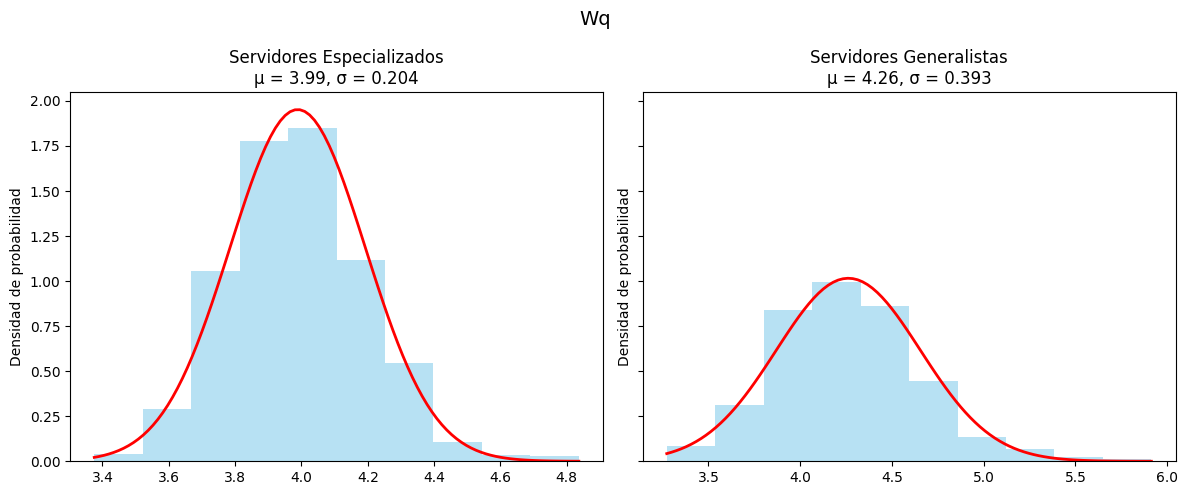

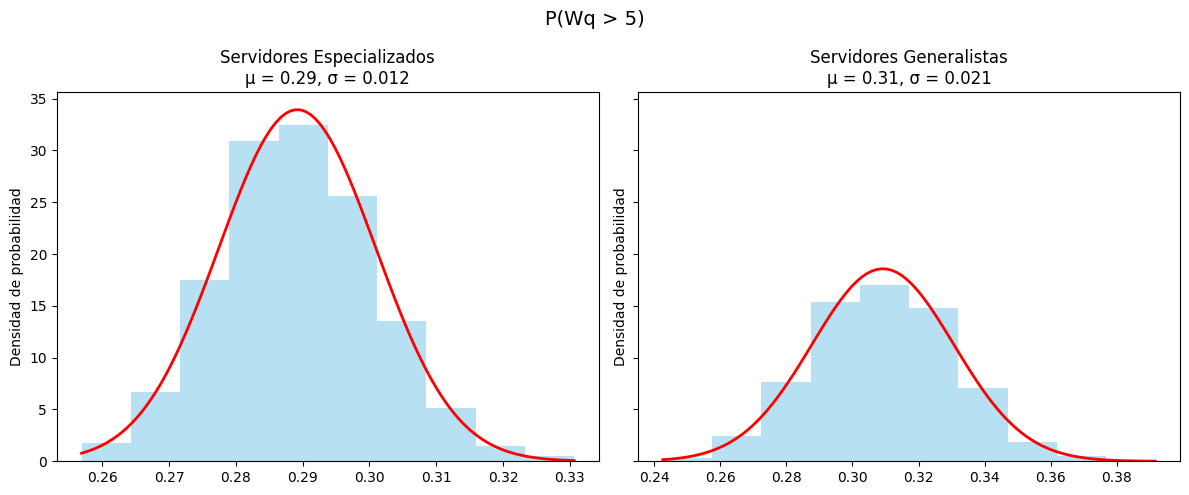

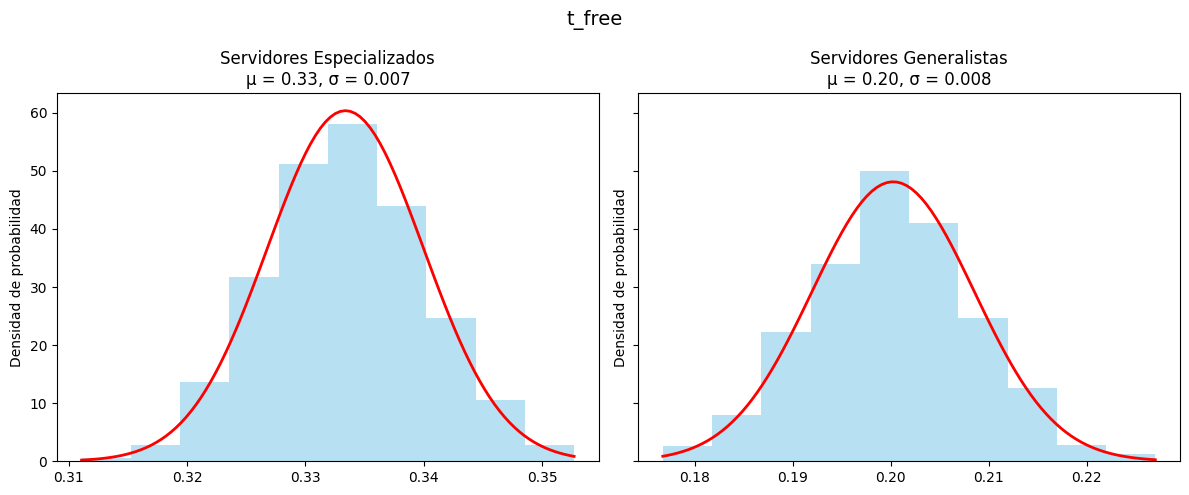

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def run_multiple_simulations(n, s, lambda1, lambda2, t1, t2, tk, sim_time):
    """
    Ejecuta múltiples simulaciones y recolecta métricas
    """
    metrics = {
        'L': [],
        'Wq': [],
        'P_Wq_over_tk': [],
        't_free': []
    }

    for _ in range(n):
        result = simulate(s, lambda1, lambda2, t1, t2, tk, sim_time)
        for key in metrics:
            metrics[key].append(result[key])

    return metrics

def plot_combined_metric(metric_name, data_esp, data_gen, bins=10):


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle(f'{metric_name}', fontsize=14)



    # Estrategia especializada
    mu_esp, sigma_esp = np.mean(data_esp), np.std(data_esp)
    ax1.hist(data_esp,bins=10,density=True,alpha=0.6,color='skyblue')
    x_esp = np.linspace(min(data_esp), max(data_esp), 100)
    ax1.plot(x_esp, norm.pdf(x_esp, mu_esp, sigma_esp), 'r-', linewidth=2)
    ax1.set_title(f'Servidores Especializados\nμ = {mu_esp:.2f}, σ = {sigma_esp:.3f}')

    # Estrategia generalista
    mu_gen, sigma_gen = np.mean(data_gen), np.std(data_gen)
    ax2.hist(data_gen, bins=10,density=True,alpha=0.6,color='skyblue')
    x_gen = np.linspace(min(data_gen), max(data_gen), 100)
    ax2.plot(x_gen, norm.pdf(x_gen, mu_gen, sigma_gen), 'r-', linewidth=2)
    ax2.set_title(f'Servidores Generalistas\nμ = {mu_gen:.2f}, σ = {sigma_gen:.3f}')

    # Etiquetas comunes
    for ax in [ax1, ax2]:
        ax.set_ylabel('Densidad de probabilidad')

    plt.tight_layout()
    plt.show()
    plt.close()


results_specialized = run_multiple_simulations(1000, "specialized", 20,20,2,2,5,480)
results_general = run_multiple_simulations(1000, "generalist", 20,20,2.4,2.4,5,480)

# Ejemplo de uso después de recolectar los datos
metricas = {
    'L': (results_specialized['L'], results_general['L']),
    'Wq': (results_specialized['Wq'], results_general[ 'Wq']),
    'P(Wq > 5)': (results_specialized['P_Wq_over_tk'], results_general['P_Wq_over_tk']),
    't_free': (results_specialized['t_free'], results_general['t_free'])
}

for nombre_metrica, (datos_esp, datos_gen) in metricas.items():
    plot_combined_metric(nombre_metrica, datos_esp, datos_gen)

# Tests de Hipotésis

In [5]:
import scipy.stats as stats

# Configuración de parámetros
params = {
    'lambda1': 20,    # tasa de llegadas pagos (clientes/hora)
    'lambda2': 20,    # tasa de llegadas cobros (clientes/hora)
    't1_specialized': 2.0,   # tiempo de servicio especializado (min)
    't2_specialized': 2.0,
    't_generalist': 2.4,
    'tk': 5,          # tiempo crítico (min)
    'sim_time': 480, # tiempo de simulación por réplica (horas)
    'n_replicas': 30  # número de réplicas
}

# Función para ejecutar múltiples réplicas
def run_replicates(s, n_replicas):
    results = {'L': [], 'Wq': [], 'P_Wq_over_tk': [], 't_free': []}
    for _ in range(n_replicas):
        if s == 'specialized':
            sim_result = simulate(
                s='specialized',
                lambda1=params['lambda1'],
                lambda2=params['lambda2'],
                t1=params['t1_specialized'],
                t2=params['t2_specialized'],
                tk=params['tk'],
                sim_time=params['sim_time']
            )
        else:
            sim_result = simulate(
                s='generalist',
                lambda1=params['lambda1'],
                lambda2=params['lambda2'],
                t1=params['t_generalist'],
                t2=params['t_generalist'],
                tk=params['tk'],
                sim_time=params['sim_time']
            )
        for key in results:
            results[key].append(sim_result[key])
    return results

# Ejecutar simulaciones para ambos sistemas
specialized_results = run_replicates('specialized', params['n_replicas'])
generalist_results = run_replicates('generalist', params['n_replicas'])

# Realizar t-test para cada métrica
metrics = ['L', 'Wq', 'P_Wq_over_tk', 't_free']
for metric in metrics:
    t_stat, p_value = stats.ttest_ind(
        specialized_results[metric],
        generalist_results[metric],
        equal_var=False  # Suponer varianzas diferentes
    )
    print(f"Métrica: {metric}")
    print(f"  Especializado (media): {np.mean(specialized_results[metric]):.3f}")
    print(f"  Generalista (media): {np.mean(generalist_results[metric]):.3f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("  -> Diferencia estadísticamente significativa (p < 0.05)")
    else:
        print("  -> No hay diferencia significativa (p ≥ 0.05)")
    print("-----------------------------------")



Métrica: L
  Especializado (media): 4.045
  Generalista (media): 4.478
  p-value: 0.0000
  -> Diferencia estadísticamente significativa (p < 0.05)
-----------------------------------
Métrica: Wq
  Especializado (media): 4.051
  Generalista (media): 4.319
  p-value: 0.0002
  -> Diferencia estadísticamente significativa (p < 0.05)
-----------------------------------
Métrica: P_Wq_over_tk
  Especializado (media): 0.292
  Generalista (media): 0.313
  p-value: 0.0000
  -> Diferencia estadísticamente significativa (p < 0.05)
-----------------------------------
Métrica: t_free
  Especializado (media): 0.331
  Generalista (media): 0.199
  p-value: 0.0000
  -> Diferencia estadísticamente significativa (p < 0.05)
-----------------------------------
